In [1]:
%matplotlib inline

from pyIHACRES import ihacres_funcs
from pyIHACRES.Network import Network
from pyIHACRES.Network import StreamNode, DamNode
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

In [107]:
climate_data = pd.read_table('Murrindindi.dat', index_col=0, dayfirst=True, parse_dates=True)
climate_data.rename(columns={'P': 'Murrindindi_rain', 'E': 'Murrindindi_evap', 'Q': 'streamflow'}, inplace=True)

In [108]:
net = Network.load_network('network.yml', first_node='Murrindindi')

hist_levels = climate_data['streamflow'].values

ext_data = np.array(np.zeros(len(climate_data['Murrindindi_rain'])), dtype=[('Murrindindi_irrig', float), ])

In [143]:
from scipy import optimize
from sklearn.metrics import r2_score, mean_squared_error


level_store = []
met_score = []
score = 1e6

def obj_func(x_val, net, climate_data, ext_data, hist_levels):
    
    d, d2, e, f, scoef, alpha, a, b, flow_mod = x_val
    
    # e = 1.0  # set `e` as constant as we're feeding in ET data
    
    net.reset()
    network = net.network
    
    # before_lake_epp = network[406219]
    # before_lake_epp.set_calib_params((d, d2, e, f), scoef, alpha, a, b, flow_mod)
    
    target_node = network['Murrindindi']
    target_node.set_calib_params((d, d2, e, f), scoef, alpha, a, b, flow_mod)

    timesteps = len(climate_data)
    for ts_idx in xrange(timesteps):       
        target_node.run(ts_idx, climate_data, ext_data)
    # End for

#     metric_mse = mean_squared_error(hist_levels, target_node._outflow)
#     metric_rmse = np.sqrt(metric_mse)
    metric_r2 = r2_score(hist_levels, target_node._outflow, sample_weight=None, multioutput='uniform_average')
    # metric_mash = np.sum((hist_levels - dam_node._level)**2) / np.sum((hist_levels - np.mean(hist_levels))**2)
    
    metric = metric_r2
    
    global score
    global met_score
    if metric < score:
        global level_store
        level_store.append(target_node._outflow[:])
        score = metric
    # End if
    met_score.append(score)
    
    return -metric
# End obj_func()
    

def calib(x):
    
    d = (150.0, 550.0)
    d2 = (1.5, 20.0)
    e = (0.8, 1.1)
    f = (0.2, 1.3)
    scoef = (0.0, 3.0)
    alpha = (0.1, 0.9)
    a = (1.0, 100.0)
    b = (0.01, 2.0)
    flow_mod = (1.0, 3.0)
#     flow_mod2 = (1.0, 3.0)
    
    bnds = [d, d2, e, f, scoef, alpha, a, b, flow_mod]
    
    res = optimize.minimize(obj_func, x, method='L-BFGS-B', bounds=bnds, 
                            args=(net, climate_data, ext_data, hist_levels, ),)
    return res
# End calib()

# initial node vals
# d, d2, e, f, scoef, alpha, a, b, flow_mod
x_0 = [150, 2.0, 1.0, 0.78, 2.5, 0.5, 54.352, 0.05, 1.0]
res = calib(x_0)

In [144]:
res

      fun: -0.56464754988821575
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.86304305e-03,  -2.00641375e+00,   1.74029001e+00,
         9.25858028e+00,   0.00000000e+00,  -7.23650362e-02,
         9.01501096e-05,   3.90720445e+00,   0.00000000e+00])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1160
      nit: 16
   status: 2
  success: False
        x: array([  1.50000048e+02,   1.73235728e+00,   9.90820592e-01,
         7.24554011e-01,   2.50000000e+00,   2.27994997e-01,
         5.43519340e+01,   2.27402550e-02,   1.00000000e+00])

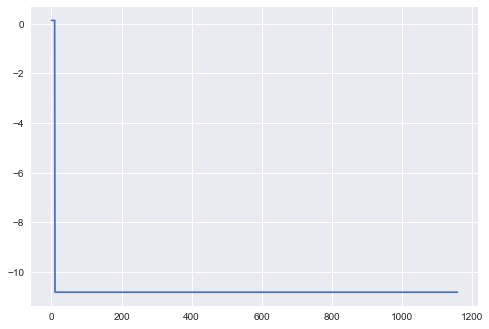

In [145]:
plt.plot(met_score)

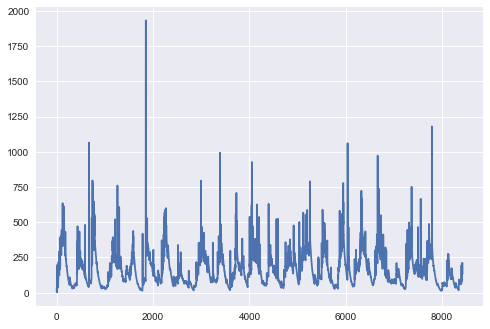

In [146]:
plt.plot(net.network['Murrindindi']._outflow)

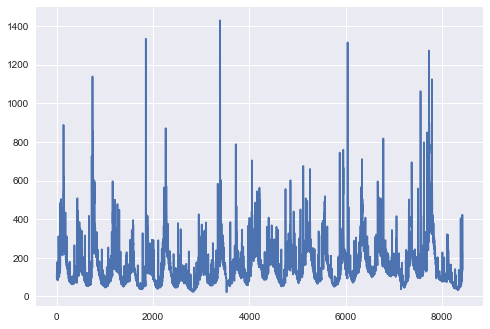

In [147]:
plt.plot(hist_levels)

In [148]:
comparison = {
    'modelled': net.network['Murrindindi']._outflow,
    'historical': hist_levels
}

dataset = pd.DataFrame(comparison)

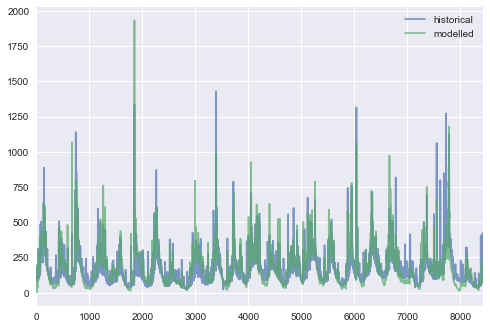

In [149]:
ax = dataset.plot(alpha=0.7);

In [150]:
res.x

array([  1.50000048e+02,   1.73235728e+00,   9.90820592e-01,
         7.24554011e-01,   2.50000000e+00,   2.27994997e-01,
         5.43519340e+01,   2.27402550e-02,   1.00000000e+00])

In [151]:
d, d2, e, f, scoef, alpha, a, b, flow_mod = res.x

In [152]:
d, d2, e, f, scoef, alpha, a, b, flow_mod

(150.00004752187542,
 1.7323572773654761,
 0.99082059153065194,
 0.72455401144013765,
 2.5,
 0.22799499697651973,
 54.351934000360998,
 0.022740255020605959,
 1.0)